# Méthode affine primale

In [1]:
using LinearAlgebra
using JuMP, HiGHS
using Plots

Considérons le problème jouet suivant.

In [2]:
m = Model(HiGHS.Optimizer)
@variable(m, x[1:2] >= 0)
@constraint(m, c1, x[1]+x[2] <= 2)
@constraint(m, c2, -x[1]+x[2] <= 1)
@objective(m, Max, x[1] + 2x[2])

print(m)

In [3]:
optimize!(m)

Presolving model
2 rows, 2 cols, 4 nonzeros
0 rows, 0 cols, 0 nonzeros
Presolve : Reductions: rows 0(-2); columns 0(-2); elements 0(-4) - Reduced to empty
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Objective value     :  3.5000000000e+00
HiGHS run time      :          0.00


In [4]:
value.(x)

2-element Vector{Float64}:
 0.5
 1.5

In [5]:
λ = -[dual(c1) ; dual(c2) ] # Nous prenons l'opposé comme il s'agit d'un problème de maximisation. 

2-element Vector{Float64}:
 1.5
 0.5

Implémentons l'algorithme affine primal.

In [6]:
mutable struct interiorPoint 
    
    k:: Int64
    K:: Int64
    
    x:: Vector  # current solution
    
    verbose
    trace
end

primalAffine = interiorPoint(0, 100, [], false, [])

interiorPoint(0, 100, Any[], false, Any[])

In [7]:
function (primalAffine:: interiorPoint)(x0:: Vector, c:: Vector, A:: Matrix, b:: Vector,
                                        ϵ:: Float64 = 1e-6)

    primalAffine.x = copy(x0)
    n = length(primalAffine.x)

    obj = dot(c,primalAffine.x)
    Δc = abs(obj)+2
    Δx = Inf*ones(n)

    if (trace)
        primalAffine.trace = [obj ; x0; zeros(n)]
        s = zeros(n)
    end
    
    γ = 0.995

    k = 0   # iteration index
    K = 100 # maximum number of iterations
    
    while ((Δc > ϵ*max(abs(obj),1)) && (k < K))
        k += 1

        X = diagm(primalAffine.x)
        # Δx := −(I − XAt(AX2At)−1AX)Xc;
        B = A*X
        Δx = -(I-B'*((B*B')\B))*X*c

        if (trace)
            s = diagm((primalAffine.x).^(-1))*Δx
            primalAffine.trace[n+2:2*n+1,k] = s
        end
    
        i = 0
        xi = 0
        for j = 1:n
            if -Δx[j] > xi
                xi = -Δx[j]
                i = j
            end
        end
        if (i == 0)
            println("Problème non borné!")
            break;
        end
        α = γ/xi
        newx = primalAffine.x+α*X*Δx
        newobj = dot(c, newx)
        Δc = obj-newobj
        obj = newobj
        primalAffine.x = newx

        if (trace)
            primalAffine.trace = hcat(primalAffine.trace, [obj ; newx; zeros(n)])
        end

    end
    
    primalAffine.k = k
    if (trace)
        # For simplicity, to avoid additional computations, we simply copy the last value of s
        primalAffine.trace[n+2:2*n+1,k+1] = s

        return (primalAffine.x).*s
    end

end

## Exemple

In [8]:
c = [-1; -2; 0; 0]
A = [1 1 1 0; -1 1 0 1]
b = [2; 1]

2-element Vector{Int64}:
 2
 1

In [9]:
# Point initial
x0 = [0.5; 0.5; 1; 1]
trace = true

slack = primalAffine(x0, c, A, b)

println(slack)

[1.7913570117439096e-14, 7.03899602068027e-15, -8.55758872493575e-10, -2.2347758824925713e-8]


In [10]:
primalAffine.trace

9×8 Matrix{Float64}:
 -1.5       -3.15833    -3.49104     …  -3.5          -3.5
  0.5        0.831667    0.499242        0.5           0.5
  0.5        1.16333     1.4959          1.5           1.5
  1.0        0.005       0.00485817      1.14101e-7    5.70506e-10
  1.0        0.668333    0.00334167      5.27988e-8    4.46955e-8
  0.666667  -0.129758    5.98177e-5  …   3.58271e-14   3.58271e-14
  1.33333    0.0663454   9.15789e-6      4.69266e-15   4.69266e-15
 -0.5       -1.53171    -1.49997        -1.5          -1.5
 -0.166667  -0.401948   -0.500025       -0.5          -0.5

In [11]:
using DelimitedFiles

open("trace.txt", "w") do f
    writedlm(f, primalAffine.trace)
end

In [12]:
k = primalAffine.k

7

In [13]:
default(size=(600,600), fc=:heat)
x, y = 0:0.02:2.0, 0:0.02:2.0
z = Surface((x,y)->dot(c[1:2],[x,y]), x, y)
Plots.contour(x,y,z, linealpha = 0.2, levels=1000)

plot!(xlims = (0.0,  2.0), ylims = (0.0, 2.0))
plot!(x -> 2-x, color = :red, linewidth = 2, label = "Contrainte 1")
plot!(x -> 1+x, color = :blue, linewidth = 2, label = "Contrainte 2")
plot!(primalAffine.trace[2,:], primalAffine.trace[3,:], lw = 3, color = :green)
scatter!(primalAffine.trace[2,:], primalAffine.trace[3,:], markersize = 4, color = :grey, label = "Itérés")

In [14]:
iterprimal = primalAffine.trace[2:5,:]
iterdual = primalAffine.trace[6:9,:]
slackness = zeros(4,k+1)
for i = 1:k+1
    slackness[:,i] = iterprimal[:,i].*iterdual[:,i]
end
slackness

4×8 Matrix{Float64}:
  0.333333  -0.107916     2.98635e-5  …   1.79136e-14   1.79136e-14
  0.666667   0.0771818    1.36993e-5      7.039e-15     7.039e-15
 -0.5       -0.00765853  -0.00728708     -1.71152e-7   -8.55759e-10
 -0.166667  -0.268635    -0.00167092     -2.63994e-8   -2.23478e-8

Regardons l'évolution des écarts de complémentarité.

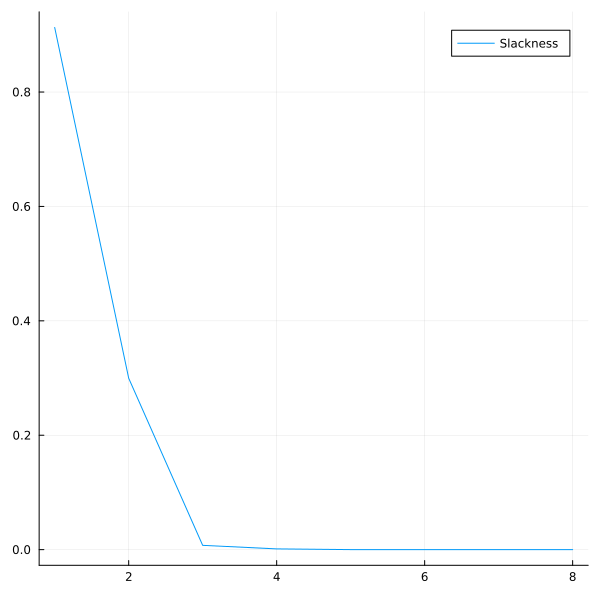

In [15]:
plot([ norm(slackness[:,i]) for i = 1:8 ], label = "Slackness")

## Exemple 2: le problème du fermier

Problème donné dans Birge et Louveaux, "Introduction to Stochastic Programming", chapitre 1.

In [16]:
c = [ 150 ; 230 ; 260 ; 238 ; 210 ; -170 ; -150 ; -36 ; -10; 0 ; 0 ; 0 ; 0 ; 0]
A = [ 1 1 1 0 0 0 0 0 0 1 0 0 0 0 ;
      2.5 0 0 1 0 -1 0 0 0 0 -1 0 0 0 ;
      0 3 0 0 1 0 -1 0 0 0 0 -1 0 0 ;
      0 0 -20 0 0 0 0 1 1 0 0 0 1 0;
      0 0 0 0 0 0 0 1 0 0 0 0 0 1]
b = [ 500 ; 200 ; 240 ; 0 ; 6000 ]

5-element Vector{Int64}:
  500
  200
  240
    0
 6000

In [17]:
x0 = [ 100 ; 100 ; 100 ; 50 ; 50 ; 50 ; 50 ; 500 ; 500 ]

9-element Vector{Int64}:
 100
 100
 100
  50
  50
  50
  50
 500
 500

In [18]:
A[:,1:9]*x0-b

5-element Vector{Float64}:
  -200.0
    50.0
    60.0
 -1000.0
 -5500.0

In [19]:
x0 = [ x0 ; 200 ; 50 ; 60 ; 1000; 5500]

14-element Vector{Int64}:
  100
  100
  100
   50
   50
   50
   50
  500
  500
  200
   50
   60
 1000
 5500

In [20]:
A*x0

5-element Vector{Float64}:
  500.0
  200.0
  240.0
    0.0
 6000.0

In [21]:
slack = primalAffine(x0, c, A, b)

println(slack)

[7.602019227942412e-8, -9.735946620884572e-8, 7.133840750112997e-10, -0.0010966544694898314, -0.00045388994982724503, 1.9585998867907192e-7, -0.001068819802379918, 1.1908984994789341e-9, -0.004556801688081789, -0.00029131736019568917, -0.00010448664405779173, -0.002880754213424889, -0.0016584527298738572, -0.004973522835076663]


In [22]:
primalAffine.x

14-element Vector{Float64}:
  119.99998718652243
   80.00002152634694
  299.9999897583099
    1.6127271609680063e-5
    1.089335879526591e-5
   99.99998349069887
    5.829926195514718e-5
 5999.999465699015
    0.00027204786197952105
    1.0593358552783531e-6
    6.146273179940913e-7
    1.7113391367109168e-5
    6.19982328931212e-5
    0.0005376781443165587

In [23]:
primalAffine.k

12